In [1]:
import polars as pl
import matplotlib.pyplot as plt
import string
import matplotlib.ticker as mtick
from swinno_bioeconomy_directionality.analysis import figures


from swinno_bioeconomy_directionality.config import PROCESSED_DATA_DIR, RAW_DATA_DIR

2024-11-11 10:12:46.021 | INFO     | swinno_bioeconomy_directionality.config:<module>:7 - PROJ_ROOT path is: /Users/research/projects/swinno_bioeconomy_directionality


In [2]:
bioeconomy_share = pl.read_csv(PROCESSED_DATA_DIR / "swinno_bioeconomy_share.csv")

In [3]:
bioeconomy_share.head()

year,n_bioeconomy,n_innovation,share_bioeconomy,ma5_n_innovation,ma5_n_bioeconomy,ma5_share_bioeconomy
i64,i64,i64,f64,f64,f64,f64
1970,17,79,0.21519,null,null,null
1971,19,85,0.223529,null,null,null
1972,16,91,0.175824,null,null,null
1973,16,84,0.190476,null,null,null
1974,17,74,0.22973,82.6,17.0,0.20695


In [4]:
def plot_innovation_metrics(shares):
    """
    Plots network metrics for innovation and actor counts in a 2x1 layout.

    Parameters:
    shares (polars.DataFrame): DataFrame containing the network metrics.

    Returns:
    matplotlib.figure.Figure: The resulting figure with subplots.
    """
    fig = plt.figure(figsize=(10, 4))
    subfigs = fig.subfigures(2, 1)

    def plot_counts(ax, y, label, x=shares["year"]):
        ax.plot(
            x, y, linestyle="--", marker="o", alpha=0.15, label=label, color="black"
        )

    def plot_ma(ax, y, label, x=shares["year"]):
        ax.plot(x, y, label=label, color="black", linewidth=2)

    axs_top = subfigs[0].subplots(1, 2)
    # Metrics for count plots (top two subfigures)
    count_metrics = [
        ("n_innovation", "Total SWINNO", axs_top[0]),
        ("n_bioeconomy", "Bioeconomy", axs_top[1]),
    ]

    for metric, title, ax in count_metrics:
        plot_counts(ax, shares[metric].to_numpy(), metric.replace("_", " ").title())
        plot_ma(ax, shares[f"ma5_{metric}"], "5 MA")
        ax.set_ylabel("Innovation Count")
        ax.set_title(title)
        ax.legend(["n Innovation", "5 MA"])

    # Share plot (bottom subfigure)
    share_ax = plt.subplot(2, 1, 2)
    plot_counts(share_ax, shares["share_bioeconomy"].to_numpy(), "Share of Innovation")
    plot_ma(share_ax, shares[f"ma5_share_bioeconomy"].to_numpy(), "5 MA")
    share_ax.set_ylabel("% Bioeconomy Innovation")
    share_ax.yaxis.set_major_formatter(mtick.PercentFormatter(xmax=1, decimals=0))
    share_ax.set_ylim(0, 0.4)
    share_ax.set_title("% Bioeconomy")
    share_ax.legend()

    # Common x-axis settings
    for ax in fig.get_axes():
        ax.set_xticks(shares["year"][::10])
        ax.set_xlabel("Year")
        ax.spines["top"].set_visible(False)
        ax.spines["right"].set_visible(False)

    # Add subfigure labels
    for n, ax in enumerate(fig.get_axes()):
        ax.text(-0.1, 1.1, string.ascii_lowercase[n], transform=ax.transAxes, size=14)

    plt.tight_layout()
    return fig

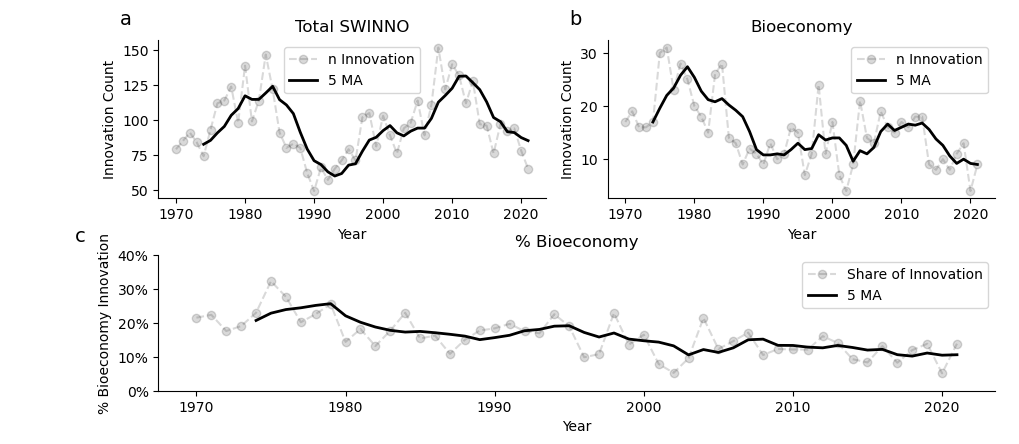

In [5]:
share_plot = plot_innovation_metrics(bioeconomy_share)
figures.save_fig(share_plot, "share_test")

In [6]:
bioeconomy_visions = pl.read_csv(RAW_DATA_DIR / "bioeconomy_visions.csv").with_columns(
    pl.col("bioeconomy_vision").str.replace("Not Bioeconomy", "Vision Neutral")
)

In [7]:
vision_summary = bioeconomy_visions.group_by("bioeconomy_vision").agg(
    pl.col("sinno_id").n_unique().alias("sum")
)

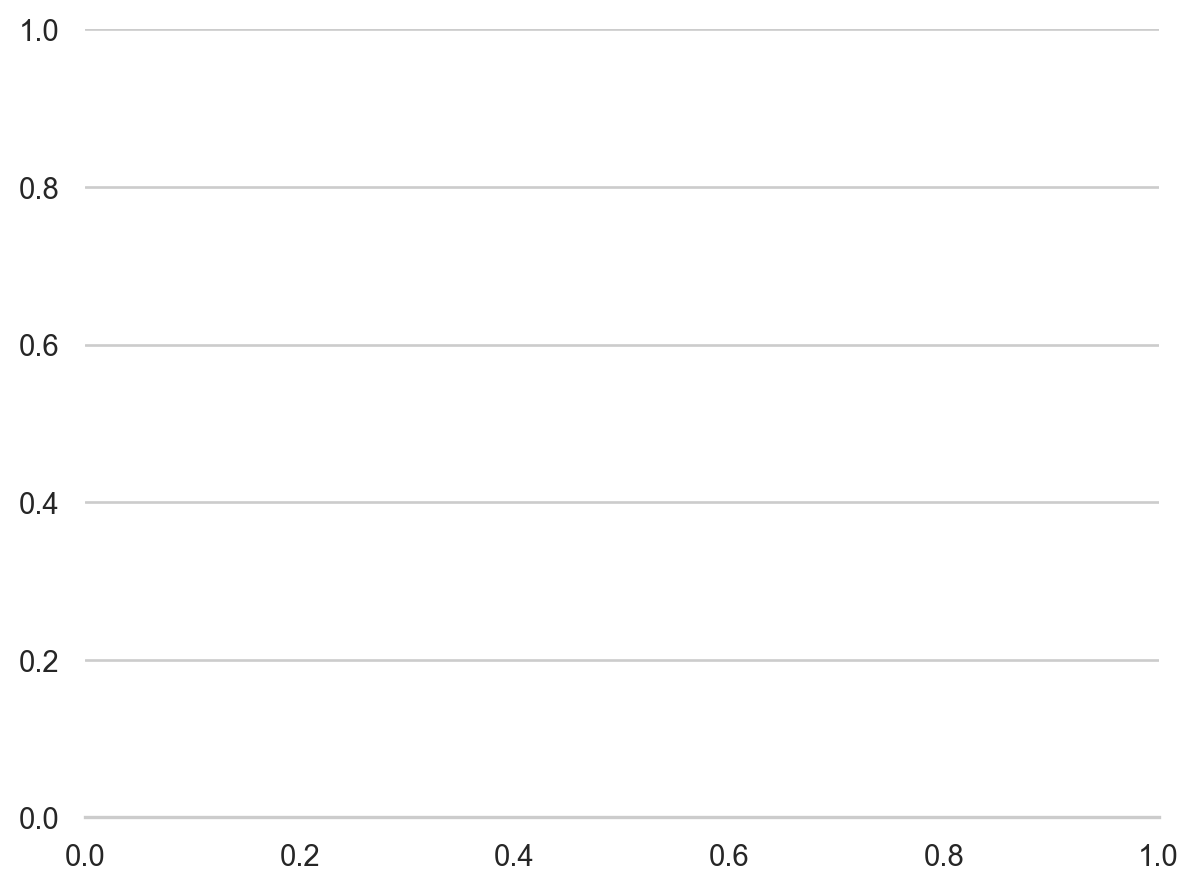

In [8]:
import seaborn.objects as so
from cmcrameri import cm
from seaborn import axes_style
import seaborn as sns
import matplotlib.ticker as mticker

theme_dict = {
    **axes_style("whitegrid"),
    "grid.linestyle": "-",
    "axes.grid.axis": "y",
    "axes.spines.top": False,
    "axes.spines.right": False,
    "axes.spines.left": False,
}

so.Plot().theme(theme_dict)

In [9]:
bv = (
    bioeconomy_visions.filter(pl.col("bioeconomy_vision") != "Unsure")
    .select("bioeconomy_vision")
    .unique()
    .to_series()
    .to_list()
)

In [10]:
batlowWS_colors = dict(zip(bv, cm.batlowWS.colors[1::]))
oslo_colors = dict(zip(bv, cm.osloS.colors[3:-2:]))

In [11]:
vision_plotting_data = bioeconomy_visions.filter(
    pl.col("bioeconomy_vision") != "Unsure"
).join(vision_summary, on=["bioeconomy_vision"])

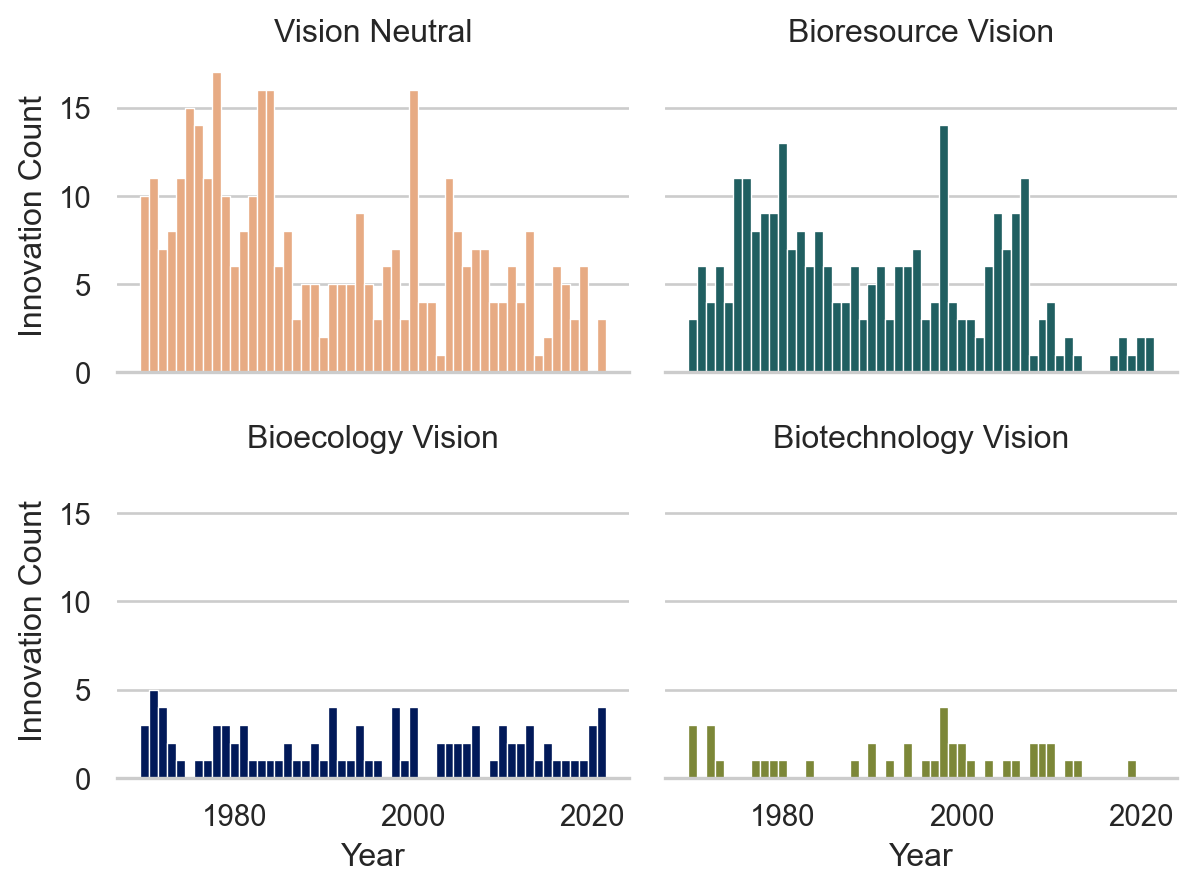

In [12]:
(
    so.Plot(vision_plotting_data, x="year", color="bioeconomy_vision", text="sum")
    .add(
        so.Bars(edgewidth=0.5, alpha=1),
        so.Agg("count"),
        y="sinno_id",
        legend=False,
    )
    .facet("bioeconomy_vision", wrap=2)
    .label(x="Year", y="Innovation Count")
).theme(theme_dict).scale(color=batlowWS_colors)

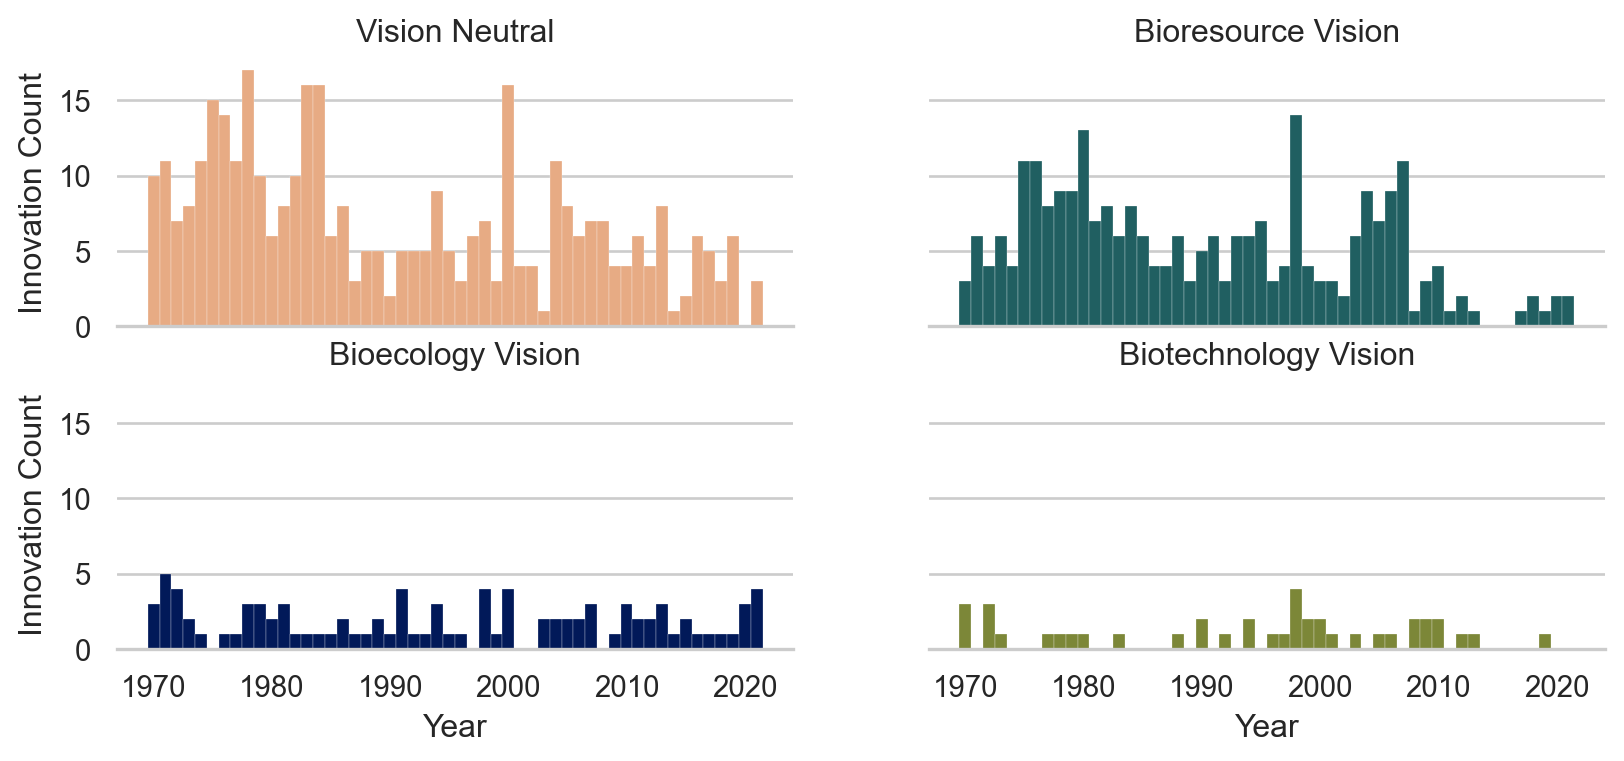

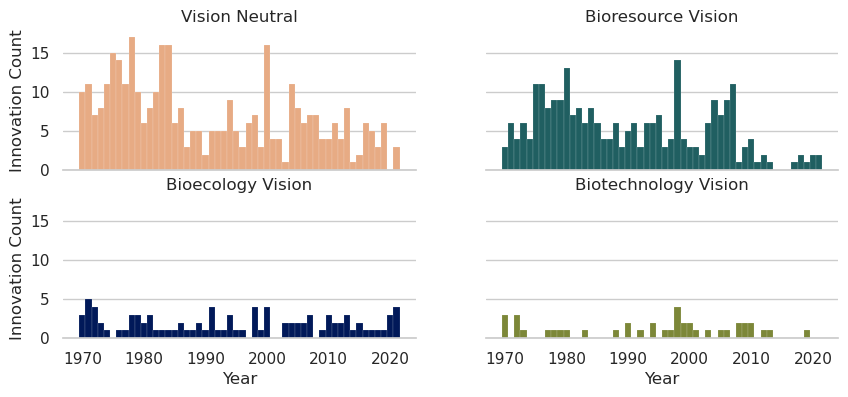

In [13]:
visions_plot = plt.figure(figsize=(10, 4))
(
    so.Plot(vision_plotting_data, x="year", color="bioeconomy_vision", text="sum")
    .add(
        so.Bars(edgewidth=0.1, alpha=1),
        so.Agg("count"),
        y="sinno_id",
        legend=False,
    )
    .facet("bioeconomy_vision", wrap=2)
    .label(x="Year", y="Innovation Count")
    .on(visions_plot)
).theme(theme_dict).scale(color=batlowWS_colors)


In [14]:
for ax in visions_plot.axes:
    ax_title = ax.get_title()
    ax.yaxis.set_major_locator(mticker.MultipleLocator(2))
    total = (
        vision_summary.filter(pl.col("bioeconomy_vision") == ax_title)
        .select("sum")
        .item()
    )
    ax.annotate(
        f"\\textbf{{Total: {total}}}",
        (2010, 12.5),
        fontweight="900",
        color=batlowWS_colors[ax_title],
    )

figures.save_fig(visions_plot, "vision_plot")